The dataset we use in this project is the [Brain Tumor MRI dataset](https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c). This contains MRI scans of multiple patients with different kinds of tumors, and many images of brains without any tumors. Being an image classification problem, we will use a **CNN ResNet** to classify these tumors (and lack thereof) into their appropriate categories. 

# Imports and Downloads

In [ ]:
%pip install --quiet opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 79.1 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import opendatasets as od
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: geetmankar
Your Kaggle Key: ··········


100%|██████████| 188M/188M [00:01<00:00, 99.9MB/s]


# Data Preparation and Exploration

Save the data directory as a variable

In [ ]:
DATA_DIR = './brain-tumor-mri-images-44c/'
#os.listdir(DATA_DIR)

Let's check the dataset

In [ ]:
dataset = ImageFolder(DATA_DIR, transform=tt.ToTensor())

In [ ]:
print("No. of classes:",len(dataset.classes),"\n")
dataset.classes

No. of classes: 44 



['Astrocitoma T1',
 'Astrocitoma T1C+',
 'Astrocitoma T2',
 'Carcinoma T1',
 'Carcinoma T1C+',
 'Carcinoma T2',
 'Ependimoma T1',
 'Ependimoma T1C+',
 'Ependimoma T2',
 'Ganglioglioma T1',
 'Ganglioglioma T1C+',
 'Ganglioglioma T2',
 'Germinoma T1',
 'Germinoma T1C+',
 'Germinoma T2',
 'Glioblastoma T1',
 'Glioblastoma T1C+',
 'Glioblastoma T2',
 'Granuloma T1',
 'Granuloma T1C+',
 'Granuloma T2',
 'Meduloblastoma T1',
 'Meduloblastoma T1C+',
 'Meduloblastoma T2',
 'Meningioma T1',
 'Meningioma T1C+',
 'Meningioma T2',
 'Neurocitoma T1',
 'Neurocitoma T1C+',
 'Neurocitoma T2',
 'Oligodendroglioma T1',
 'Oligodendroglioma T1C+',
 'Oligodendroglioma T2',
 'Papiloma T1',
 'Papiloma T1C+',
 'Papiloma T2',
 'Schwannoma T1',
 'Schwannoma T1C+',
 'Schwannoma T2',
 'Tuberculoma T1',
 'Tuberculoma T1C+',
 'Tuberculoma T2',
 '_NORMAL T1',
 '_NORMAL T2']

We see above that there are 44 classes, but after googling MRI image types, we come to know that T1, T1C+, T2, etc. are just types of weighted MRI images depending on what the operator wants to focus on (e.g., water, fatty tissue, etc.). Knowing this we understand that ***Papiloma T1*** and ***Papiloma T1C+*** refer to the sam ekind of tumor, just in different kind of image. So we now need to create a dataset class extending the `Dataset` class from `torch.utils.data` to separate the type of image from the tumor name, and then see how many classes that leaves us with.

In [ ]:
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from torchvision.io import read_image, ImageReadMode
import pandas as pd

In [ ]:
class BrainTumorDataset(Dataset):
    
    def __init__(self, base_dir, transforms = None):
        """
        Arguments:
            base_dir: str
                Directory where the dataset is stored
            transforms: iterable
                Collection of transforms to apply when loading an image
        """
        super().__init__()
        self.base_dir = Path(base_dir)
        self.transforms = transforms
        
        self.data_dicts = []
        for img in self.base_dir.glob("*oma*/*.jp*g"):
            # Get all images of sick patients, every tumor name contains "oma" 
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"],img_dict["img_type"] = img.parent.name.split(" ")
            self.data_dicts.append(img_dict)
            
        for img in self.base_dir.glob("*NORMAL*/*.jp*g"):
            # Get all images of normal patients    
            img_dict = {}
            img_dict["img_path"] = img
            img_dict["label"], img_dict["img_type"] = "Normal", img.parent.name.split(" ")[1]
            self.data_dicts.append(img_dict)
        
        self.data = pd.DataFrame(self.data_dicts)
        self.labels = self.data["label"]
        
        self.encoder = LabelEncoder()
        self.y = self.encoder.fit_transform(self.labels)
        self.classes = list(self.encoder.classes_)
        self.num_classes = len(self.classes)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # read image into a Tensor
        image = read_image(str(self.data.loc[idx,"img_path"]), mode=ImageReadMode.RGB)
        image = TF.to_pil_image(image)
        # read corresponding label 
        label = self.y[idx]
        
        if self.transforms is not None:
            return self.transforms(image), label
        else:
            return image, label
    
    
    def display(self,idxs):
        """
        Display a few images from the dataset.
        Arguments:
            idxs: iterable
                Collection of indices of the images that will be displayed
        Returns:
            fig, axs:
                Matplotlib Figure and List(Axes) where the images are rendered
                
        
        Example: 
            BrainDataset().display([1,2])
        """
        
        img_list = [TF.to_pil_image(self[idx][0]) for idx in idxs]
            
        labels = [self.labels[idx] for idx in idxs]
        
        fig,axs = plt.subplots(ncols=len(idxs),
                               nrows=1,
                               squeeze=False,
                               figsize=(10, len(idxs)*16))
        
        for i,ax in enumerate(axs.flat):
            ax.imshow(img_list[i],cmap='gray')
            ax.set_title(labels[i],size=8)
            ax.grid()
            ax.axis('off')
            
        return fig, axs
    
    def _ipython_display_(self):
        # Render the underlying DataFrame when asked to display self in a notebook
        display(self.data)

**Instantiate the dataset**

In [ ]:
dataset = BrainTumorDataset(DATA_DIR, tt.ToTensor())

**Names and Number of Classes:**

In [ ]:
num_classes = len(dataset.classes)
print(f"No. of classes: {num_classes}\n")
dataset.classes

No. of classes: 15



['Astrocitoma',
 'Carcinoma',
 'Ependimoma',
 'Ganglioglioma',
 'Germinoma',
 'Glioblastoma',
 'Granuloma',
 'Meduloblastoma',
 'Meningioma',
 'Neurocitoma',
 'Normal',
 'Oligodendroglioma',
 'Papiloma',
 'Schwannoma',
 'Tuberculoma']

That leaves us with 15 classes, which should make it easier for the classifier since it doesn't have to differentiate between ***Astrocitoma T1*** and ***Astrocitoma T1C+***. 

**Image Shape, and Encoded Label**

In [ ]:
img, label = dataset[0]
print(f"{img.shape=}, {label=}")

img.shape=torch.Size([3, 630, 630]), label=13


(<Figure size 720x3456 with 3 Axes>,
 array([[<Axes: title={'center': 'Schwannoma'}>,
         <Axes: title={'center': 'Schwannoma'}>,
         <Axes: title={'center': 'Normal'}>]], dtype=object))

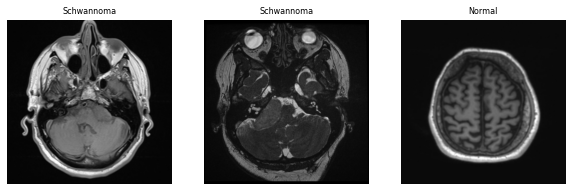

In [ ]:
dataset.display([1, 432, 4000])

In [ ]:
dataset.data

img_path       label img_type
0     brain-tumor-mri-images-44c/Schwannoma T1/0a834...  Schwannoma       T1
1     brain-tumor-mri-images-44c/Schwannoma T1/9365c...  Schwannoma       T1
2     brain-tumor-mri-images-44c/Schwannoma T1/6f06f...  Schwannoma       T1
3     brain-tumor-mri-images-44c/Schwannoma T1/0c8fc...  Schwannoma       T1
4     brain-tumor-mri-images-44c/Schwannoma T1/2b9a6...  Schwannoma       T1
...                                                 ...         ...      ...
4460  brain-tumor-mri-images-44c/_NORMAL T2/5c7c63dd...      Normal       T2
4461  brain-tumor-mri-images-44c/_NORMAL T2/4e693250...      Normal       T2
4462  brain-tumor-mri-images-44c/_NORMAL T2/df9c05ff...      Normal       T2
4463  brain-tumor-mri-images-44c/_NORMAL T2/772a7093...      Normal       T2
4464  brain-tumor-mri-images-44c/_NORMAL T2/d6a53bea...      Normal       T2

[4465 rows x 3 columns]

In [ ]:
dataset.data.describe()

img_path       label img_type
count                                                4465        4465     4465
unique                                               4465          15        3
top     brain-tumor-mri-images-44c/Schwannoma T1/0a834...  Meningioma     T1C+
freq                                                    1         874     1686

**Let's look at the number of images in each class:**

In [ ]:
import plotly.express as px
px.histogram(dataset.data, x="label")

Notice there are some categories with less than a 100 images, these classes might prove to be a little difficult to identify later due to lack of training data.

Aren't MRI images grayscale as we saw ealier? Let's sanity-check if all the channels have the same data (since that is the case for grayscale data converted into RGB).

In [ ]:
#n NO NEED TO PUT IN A RANDOM SEED
img, label = dataset[np.random.randint(0,len(dataset))]
n_channels = img.shape[0]
for i in range(n_channels):
    print( f"Channels {i%n_channels} and {(i+1)%n_channels} are the same:", 
          np.allclose(img[i%n_channels], img[(i+1)%n_channels], atol=1e-5) )

Channels 0 and 1 are the same: False
Channels 1 and 2 are the same: False
Channels 2 and 0 are the same: False


But we will use ResNet18 later, so we must keep the 3 channels.

# Augment the Data

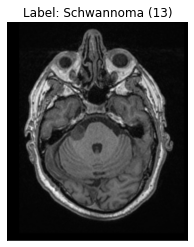

In [ ]:
def show_example(img, label):
    #print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.title(f"Label: {dataset.classes[label]} ({label})")
    ax = plt.gca()
    ax.set_xticks([]); ax.set_yticks([])
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

show_example(*dataset[123])

Notice that there are large black borders with no information surrounding the important matter in our images. This would waste computational power, so let us make a generalized cropping class to remove these borders, and add it to `nn.Module` so we can use it as a transform with pytorch easily.

In [ ]:
# to define a custom transform inherit from nn.Module and give it a forward method
class CropToContent(nn.Module):

    def __init__(self,threshold=0.1,ignore_frame_pixels=5):
        super().__init__()
        self.threshold = threshold
        self.ignore_frame_pixels = ignore_frame_pixels if ignore_frame_pixels > 0 else None

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped.
        Returns:
            Tensor: Cropped image.
        """
            
        C,H,W = img.shape
        skipH = self.ignore_frame_pixels
        skipT = -self.ignore_frame_pixels if self.ignore_frame_pixels is not None else None
        
        ymax = torch.max(torch.sum(img[:, H//2, skipH:skipT], dim=0))
        xmax = torch.max(torch.sum(img[:, skipH:skipT, W//2], dim=0))
           
        bottom, top = torch.nonzero(torch.sum(img[:,H//2,skipH:skipT], dim=0) > self.threshold*ymax)[[0,-1]]
        left, right = torch.nonzero(torch.sum(img[:,skipH:skipT,W//2], dim=0) > self.threshold*xmax)[[0,-1]]

        return TF.center_crop(img, output_size = [int(right-left), int(top-bottom)])
    
    def __repr__(self):
        return f"CropToContent(threshold={self.threshold})"

Before cropping: torch.Size([3, 630, 522])


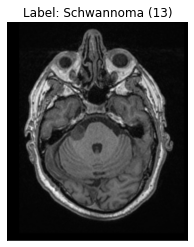

After cropping: torch.Size([3, 552, 425])


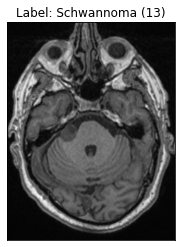

In [ ]:
# SEE HOW THE ABOVE CLASS CROPS THE IMAGE

img, label = dataset[123]
img_cropped = CropToContent(threshold=0.1, ignore_frame_pixels=5)(img)
print_string = [f"Before cropping: {img.shape}", 
               f"After cropping: {img_cropped.shape}"]
for i,j in zip([img, img_cropped], print_string):
    print(j)
    show_example(i, label)

We will use ResNet18, so our image size must be $224 \times 224$ to be fed into it. Hence we refresh the dataset with the `ToTensor()` transform, the new `CropToContent()` transform we made along with a `Resize()` transform to resize the image after.

In [ ]:
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH  = 224

In [ ]:
dataset = BrainTumorDataset(DATA_DIR, 
          transforms=tt.Compose([
              tt.ToTensor(),
              CropToContent(threshold=0.1, ignore_frame_pixels=5),
              tt.Resize([IMG_HEIGHT,IMG_WIDTH]),
              ])
          )

Let's see an image from the modified dataset

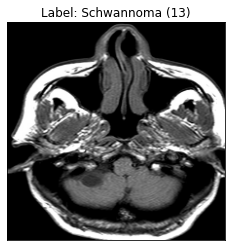

In [ ]:
show_example(*dataset[12])

Split the Data into train and validation sets, and convert them into DataLoaders

In [ ]:
torch.manual_seed(42)
val_size = int(0.1 * len(dataset))
train_set, valid_set = random_split(dataset, [len(dataset)-val_size, val_size])

train_dl = DataLoader(train_set, BATCH_SIZE  , num_workers=4, pin_memory=True, shuffle=True)
valid_dl = DataLoader(valid_set, 2*BATCH_SIZE, num_workers=4, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Let's look at section of our data

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

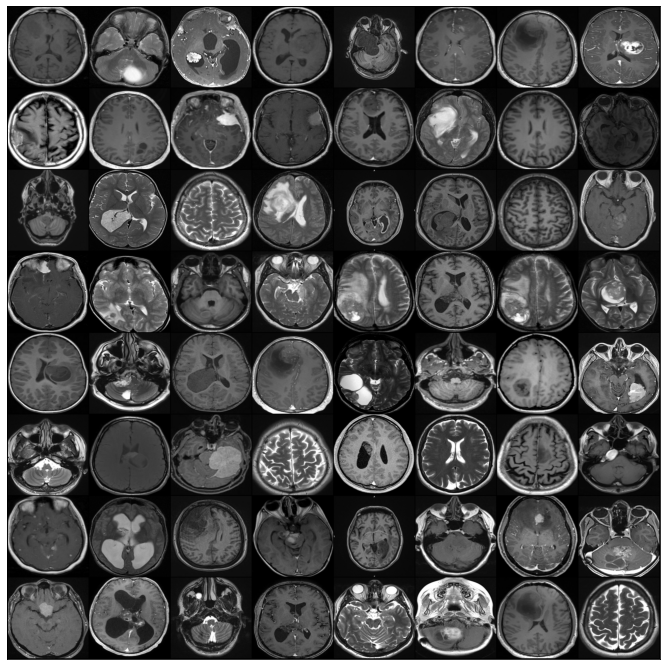

In [ ]:
show_batch(train_dl)

The data augmentations we will use after this will be from ResNet18, let's see what those augmentations are

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
resnet = resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
resnet_transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
resnet_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
transforms = torch.nn.Sequential(
    tt.RandomHorizontalFlip(),
    #tt.RandomResizedCrop([IMG_HEIGHT, IMG_WIDTH]),
    tt.RandomAutocontrast(1),
    tt.RandomRotation(10),
    resnet_transforms,
)

# Use GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out  = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out  = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc  = accuracy(out, labels)          # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss   = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs   = [x['val_acc'] for x in outputs]
        epoch_acc    = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
class TumorClassifier(ImageClassificationBase):
    def __init__(self, num_classes, transform, pretrained=True):
        super().__init__()
        #self.network = resnet18(weights="IMAGENET1K_V1"*pretrained)
        #self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        self.network =  torch.nn.Sequential(
                            transform,
                            resnet,
                            torch.nn.Linear(resnet.fc.out_features, num_classes)
                        )
    def forward(self, xb):
        return self.network(xb)

# Training

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

Move data to GPU

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Instantiate the model and move it to the GPU

In [ ]:
model = TumorClassifier(num_classes, transforms, pretrained=True)
to_device(model, device)

TumorClassifier(
  (network): Sequential(
    (0): Sequential(
      (0): RandomHorizontalFlip(p=0.5)
      (1): RandomAutocontrast(p=1)
      (2): RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
      (3): ImageClassification(
          crop_size=[224]
          resize_size=[256]
          mean=[0.485, 0.456, 0.406]
          std=[0.229, 0.224, 0.225]
          interpolation=InterpolationMode.BILINEAR
      )
    )
    (1): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Train the model

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.738827705383301, 'val_acc': 0.05222039669752121}]

In [ ]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00147, train_loss: 2.0849, val_loss: 1.5905, val_acc: 0.5362


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00431, train_loss: 1.1138, val_loss: 1.4682, val_acc: 0.5595


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00757, train_loss: 1.0355, val_loss: 1.7955, val_acc: 0.5316


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00971, train_loss: 1.0241, val_loss: 2.9708, val_acc: 0.3206


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00994, train_loss: 0.9825, val_loss: 1.3288, val_acc: 0.6053


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00950, train_loss: 0.8749, val_loss: 2.3527, val_acc: 0.4584


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00867, train_loss: 0.7384, val_loss: 1.1328, val_acc: 0.6674


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00750, train_loss: 0.6714, val_loss: 0.9483, val_acc: 0.7177


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00611, train_loss: 0.5173, val_loss: 0.9442, val_acc: 0.7245


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00463, train_loss: 0.4233, val_loss: 0.8659, val_acc: 0.7689


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00317, train_loss: 0.3452, val_loss: 1.1739, val_acc: 0.6890


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00188, train_loss: 0.2509, val_loss: 0.5798, val_acc: 0.8428


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00087, train_loss: 0.1670, val_loss: 0.6817, val_acc: 0.8344


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00022, train_loss: 0.1379, val_loss: 0.5565, val_acc: 0.8461


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00000, train_loss: 0.1320, val_loss: 0.6062, val_acc: 0.8264
CPU times: user 1min 15s, sys: 19 s, total: 1min 34s
Wall time: 7min 42s


In [ ]:
train_time="7min 42s"

# Visualise the Results

**Training Accuracy:**

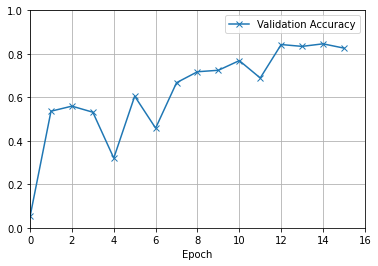

In [ ]:
epoch_list = list(range(epochs+1))
val_accs = [i['val_acc' ] for i in history]
val_loss = [i['val_loss'] for i in history]

plt.plot(epoch_list, val_accs,'x-', label="Validation Accuracy",)

plt.xlim(0,epochs+1)
plt.ylim(0,1)
plt.legend()
plt.xlabel('Epoch')
plt.grid(which='major',ls='-')
plt.grid(which='minor',ls='--')

**Training Loss vs. Validation Loss:**

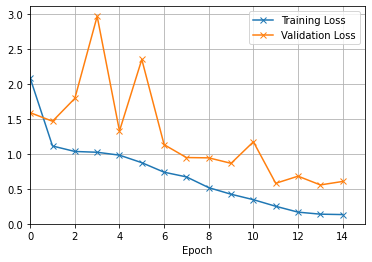

In [ ]:
epoch_list = list(range(epochs))
train_loss = [ i['train_loss'] for i in history[1:] ]
val_loss   = [ i['val_loss'  ] for i in history[1:] ]

plt.plot(epoch_list, train_loss,'x-', label="Training Loss"  )
plt.plot(epoch_list, val_loss  ,'x-', label="Validation Loss")

plt.xlim(0,epochs)
plt.ylim(bottom=0)#,1)
plt.legend()
plt.xlabel('Epoch')
plt.grid(which='major',ls='-')
plt.grid(which='minor',ls='--')

## Predict the type of tumor on images

**Let's create a helper function to make predictions:**

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

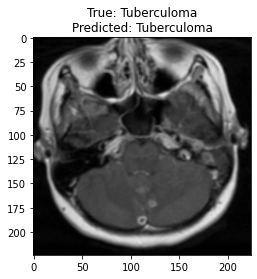

In [ ]:
img, label = valid_set[16]
plt.title(f"True: {dataset.classes[label]}\nPredicted: {predict_image(img, model)}")
plt.imshow(img.permute(1, 2, 0))

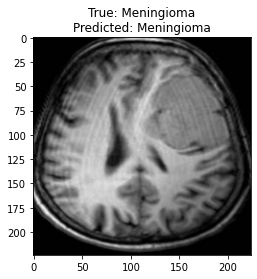

In [ ]:
img, label = valid_set[1]
plt.title(f"True: {dataset.classes[label]}\nPredicted: {predict_image(img, model)}")
plt.imshow(img.permute(1, 2, 0))

Text(0.5, 1.0, 'True: Glioblastoma\nPredicted: Glioblastoma')

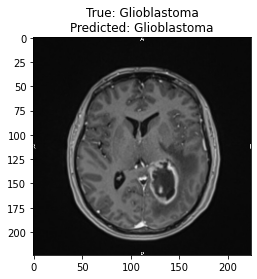

In [ ]:
img, label = valid_set[300]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"True: {dataset.classes[label]}\nPredicted: {predict_image(img, model)}")

**But which classes are hard to classify?**

<ipython-input-82-8465e78f0a31>:10: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



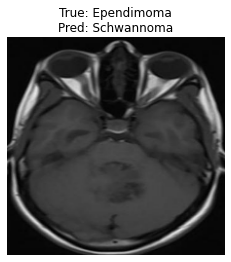

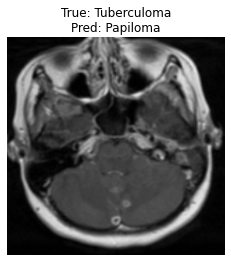

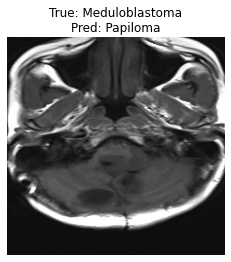

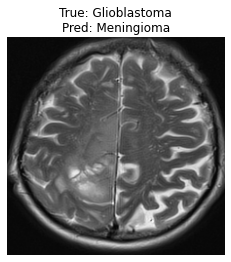

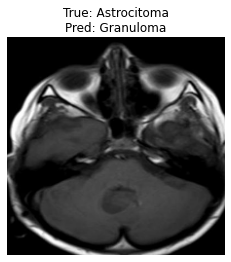

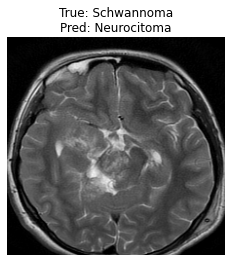

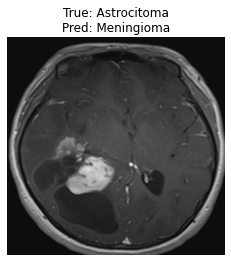

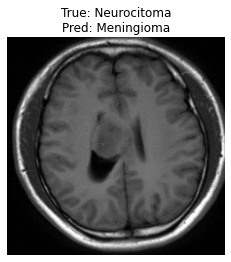

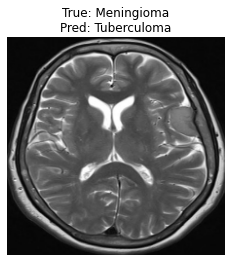

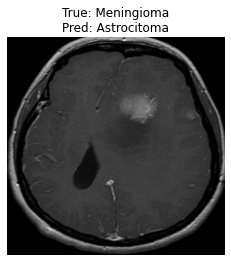

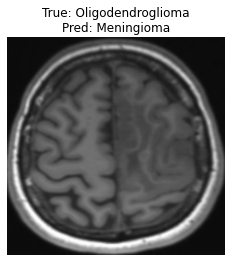

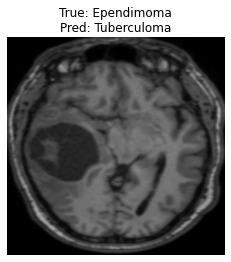

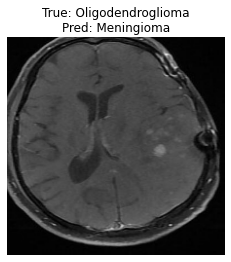

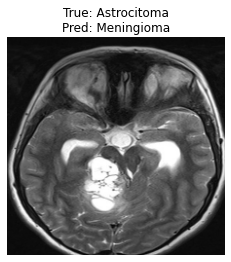

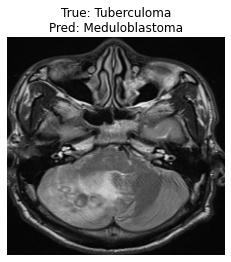

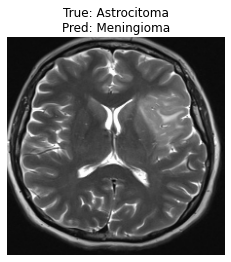

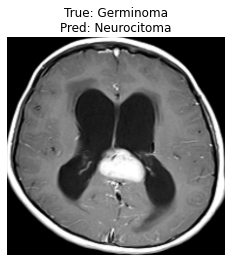

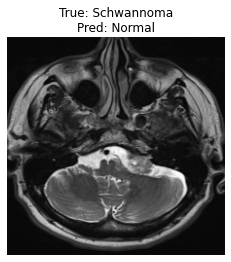

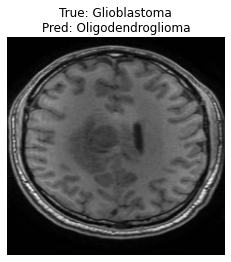

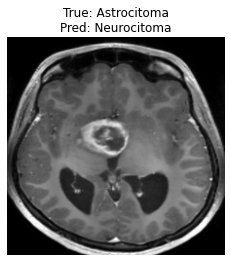

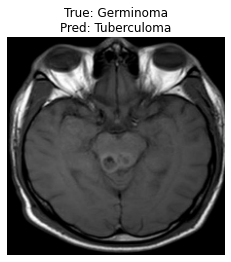

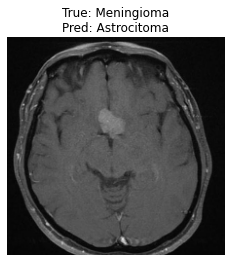

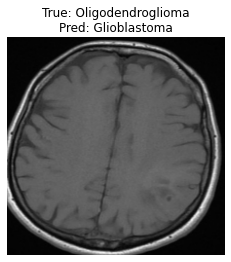

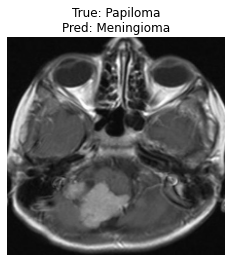

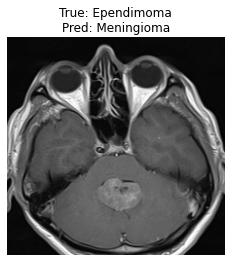

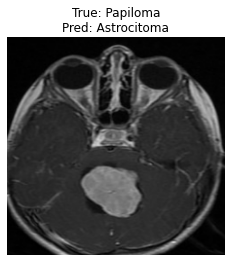

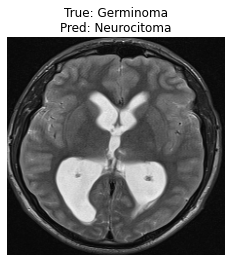

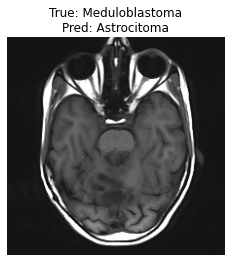

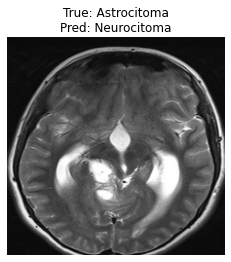

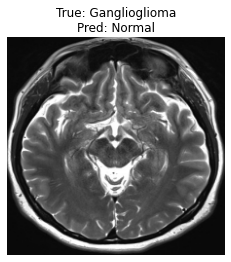

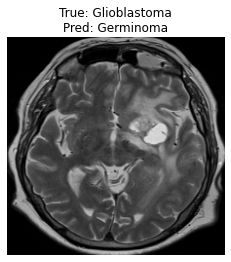

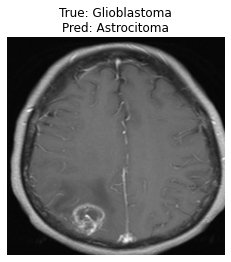

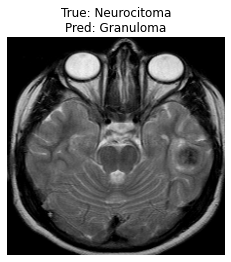

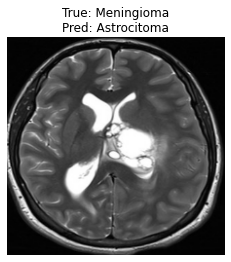

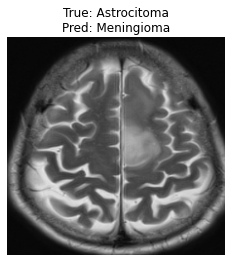

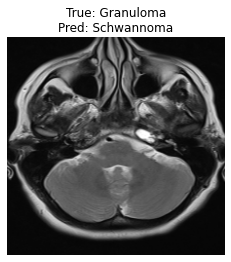

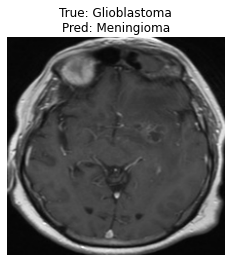

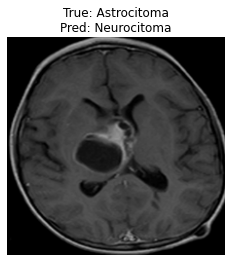

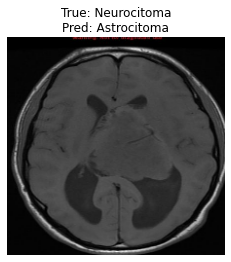

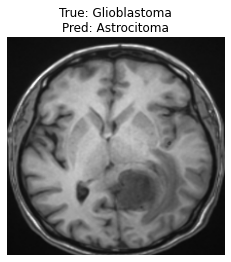

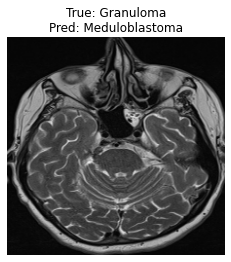

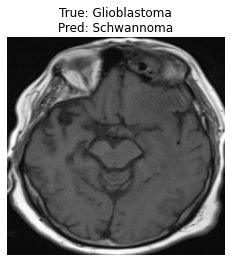

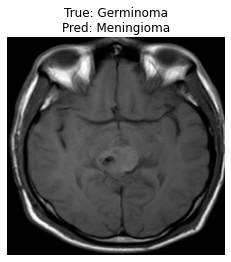

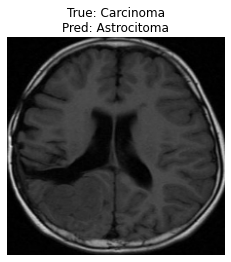

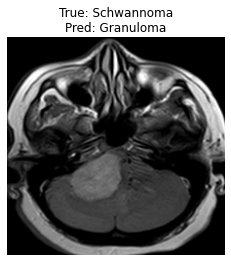

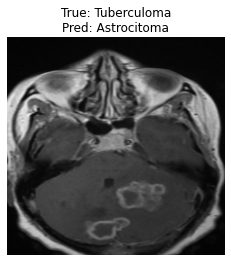

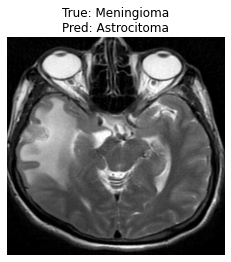

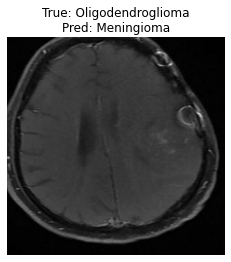

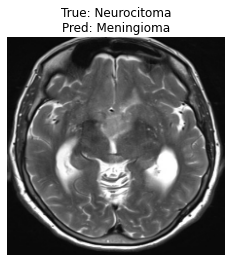

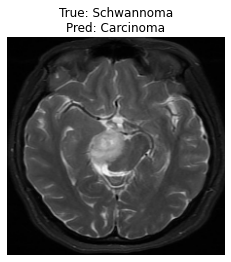

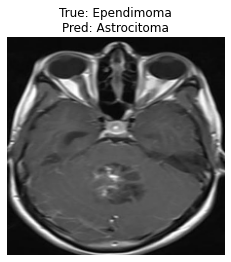

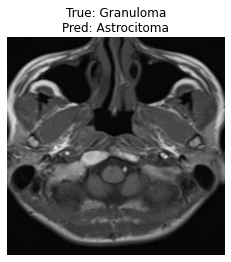

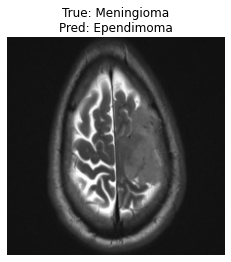

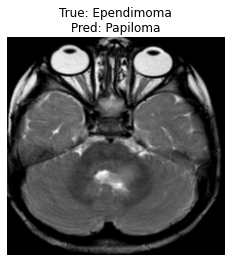

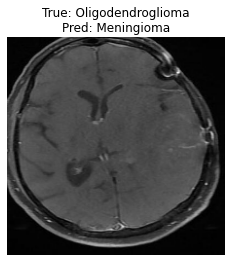

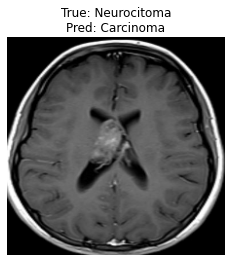

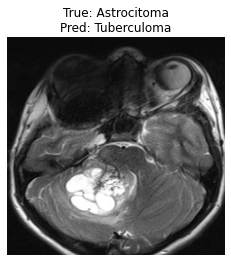

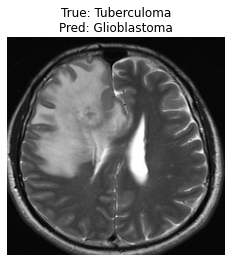

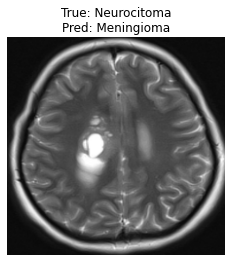

In [ ]:
model.eval()

with torch.inference_mode():
    for data,label in valid_dl:
        pred_labels = torch.argmax(model(data), dim=1)
        
        idxs = torch.nonzero(pred_labels != label).T[0]
        
        for i in idxs:
            plt.figure()
            img = data[i]
            plt.imshow(TF.to_pil_image(img))
            true = dataset.classes[label[i]]
            pred = dataset.classes[pred_labels[i]]
            plt.axis("off")
            plt.grid()
            plt.title(f"True: {true}\nPred: {pred}")

# Model Stats and Hyperparameters

In [ ]:
finaldict = evaluate(model, valid_dl)
print(
    f"Final Validation Loss: {finaldict['val_loss']:.3f}",
    f"\nFinal Validation Accuracy: {finaldict['val_acc']:.3f}",
)

Final Validation Loss: 0.584 
Final Validation Accuracy: 0.860


Text(0.5, 1.0, 'Learning Rate vs. Batch no.')

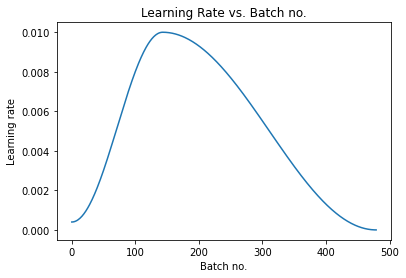

In [ ]:
lr_history = np.concatenate([x.get('lrs', []) for x in history[1:]])
#lr_history = lr_history
plt.plot(lr_history)
plt.xlabel('Batch no.')
plt.ylabel('Learning rate')
plt.title('Learning Rate vs. Batch no.')

In [ ]:
print({
    'arch': "resnet18",
    'num_epochs': epochs,
    'scheduler':'one-cycle', 
    'weight_decay':weight_decay,
    'opt_func': opt_func.__name__,
    'batch_size': BATCH_SIZE,
    'lr': max_lr,
})

{'arch': 'resnet18', 'num_epochs': 15, 'scheduler': 'one-cycle', 'weight_decay': 1e-05, 'opt_func': 'Adam', 'batch_size': 128, 'lr': 0.01}


In [ ]:
print({
    "val_loss":history[-1]['val_loss'], 
    "val_acc":history[-1]['val_acc'],
    "train_loss":history[-1]['train_loss'],
    "time":train_time
})

{'val_loss': 0.606174111366272, 'val_acc': 0.8263775110244751, 'train_loss': 0.1319696307182312, 'time': '7min 42s'}


# Saving and Loading the Model

In [ ]:
torch.save(model.state_dict(), 'braintumor_resnet18_v2.pth')

In [ ]:
model2 = to_device(TumorClassifier(num_classes, transforms, pretrained=True),
                   device)

In [ ]:
model2.load_state_dict(torch.load('braintumor_resnet18_v2.pth'))

<All keys matched successfully>

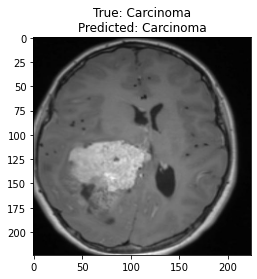

In [ ]:
img, label = valid_set[24]
plt.title(f"True: {dataset.classes[label]}\nPredicted: {predict_image(img, model2)}")
plt.imshow(img.permute(1, 2, 0))

In [ ]:
model2dict = evaluate(model2, valid_dl)
print(f"For model2 (The model loaded from the saved .pth file)"
    f"\nFinal Validation Loss: {finaldict['val_loss']:.3f}",
    f"\nFinal Validation Accuracy: {finaldict['val_acc']:.3f}",
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



For model2 (The model loaded from the saved .pth file)
Final Validation Loss: 0.584 
Final Validation Accuracy: 0.860


The validation losss and accuracies for the original `model` and the model loaded from saved .pth file `model2` are the same.

# Conclusions

* 86% accuracy is achieved after training for 15 epochs (7min 42s) which is pretty good. Training for longer will ofcourse increase the accuracy.


* As we noted earlier, these images, even though they are grayscale, have 3 channels with the exact same data in them. This is a waste of some computational power, although I believe this power is compensated by the ResNet18 pretrained model we use for transfer learning here. Regradless, removing these channels and finding a pretrained grayscale image model will potentially save time and power.

* There are some classes, as seen in the Data Exploration section, that have very little training samples to work with, causing a lack of accuracy in the predictions. (See earlier cells)

* There are some examples with wrong predictions, where an image with a tumor is predicted to be normal. This is highly dangerous and undesirable behaviour from a tumor identification model. This is out of my area of expertise, but having more anonymized but tightly connected medical information along with the MRI images, for each patient, would certainly help to improve the diagnostic capabilities in a more complex model. Giving any more suggestions would require me to learn more about the field.






